# พลอตผลการ preprocessing radar moments จนถึงการจำแนกชนิดหยาดน้ำฟ้า

* 2022.12.18
* 1. การขจัด clutter กับ noise ใช้ SNR
* 2. การปรับแก้ค่า differential phase fields ได้แก่ Differential Phase Shift (ΦDP or PHI) ใ และคำนวณค่า Specific Differential Phase (KDP)
* 3. การปรับแก้ attenuation correction of reflectivity
* 4. จำแนกชนิดหยาดน้ำฟ้า HID/HCA


In [1]:
import numpy as np
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt

import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\mpl_toolkits\basemap\__init__.py:33: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _matplotlib_version = LooseVersion(_matplotlib_version)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\mpl_toolkits\basemap\__init__.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _mpl_required_version = LooseVersion('0.98')


In [2]:
files = './0data/0Hail_CRI23Apr2020/CRI240@202004231215.uf'
print(files)
radar = pyart.io.read(files)

./0data/0Hail_CRI23Apr2020/CRI240@202004231215.uf


In [3]:
print(radar.fields.keys())

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase'])


# 1. การขจัด clutter กับ noise ใช้ SNR

## พลอตดูภาพจาก TMD chiangrai

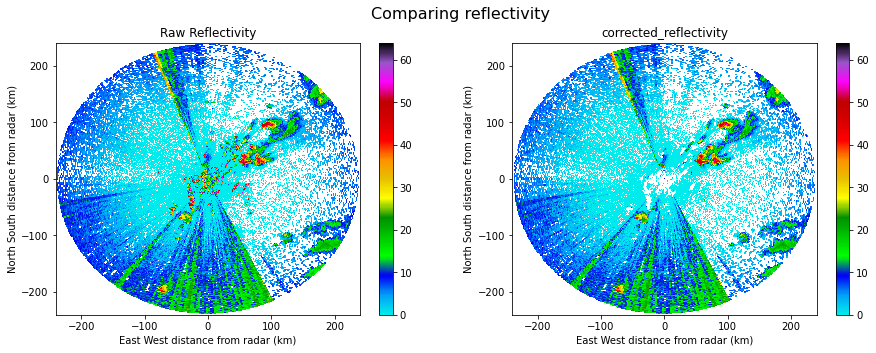

In [4]:
# create the plot
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('reflectivity', 0, ax=ax1, vmin=0, vmax=64., 
                 colorbar_label='', cmap=pyart.graph.cm.NWSRef,
                 title='Raw Reflectivity')

ax2 = fig.add_subplot(122)
display.plot_ppi('corrected_reflectivity', 0, vmin=0, vmax=64., 
                 colorbar_label='', cmap=pyart.graph.cm.NWSRef, ax=ax2,
                 title='corrected_reflectivity')


plt.suptitle('Comparing reflectivity', fontsize=16)
plt.show()

ภาพขวา corrected_reflectivity บริเวณตรงกลางมีการขจัดค่า ground clutter ออกไป แต่ก็เป็นข้อมูลที่ได้จากอัลกอริทึ่มใน EEC Edge ทำให้ไม่สามารถปรับแต่งค่าเช่น attenuation ในขั้นต่อไปได้ จึงต้องหาทางจัดการ clutter กับ noise จากข้อมูล raw ด้วยวิธีการ https://openradarscience.org/erad2022/notebooks/pyart/exercice1_swiss_thunderstorm.html โดยจะต้องทำการ retrieve ค่า signal to noise ratio ก่อน

## หาค่า signal to noise ratio 

In [5]:
snr = pyart.retrieve.calculate_snr_from_reflectivity(radar, refl_field='reflectivity',toa=15000.0) #15000 ทดลองเอง
radar.add_field('signal_to_noise_ratio', snr, replace_existing=True)

In [6]:
print(radar.fields.keys())

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio'])


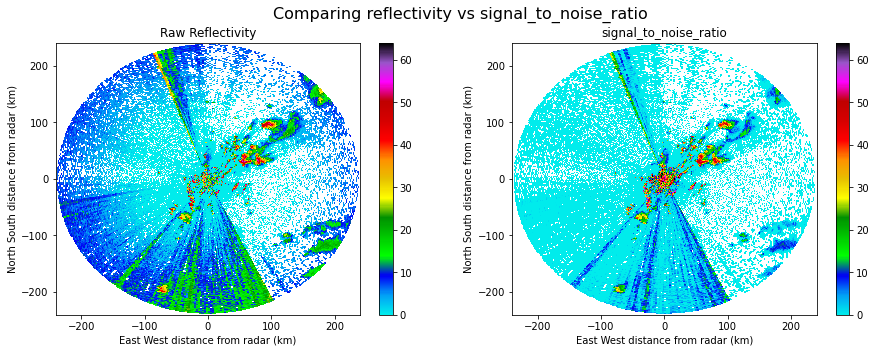

In [7]:
# create the plot
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('reflectivity', 0, ax=ax1, vmin=0, vmax=64., 
                 colorbar_label='', cmap=pyart.graph.cm.NWSRef,
                 title='Raw Reflectivity')

ax2 = fig.add_subplot(122)
display.plot_ppi('signal_to_noise_ratio', 0, vmin=0, vmax=64., 
                 colorbar_label='', cmap=pyart.graph.cm.NWSRef, ax=ax2,
                 title='signal_to_noise_ratio')

plt.suptitle('Comparing reflectivity vs signal_to_noise_ratio', fontsize=16)
plt.show()

* สังเกตุภาพขวา ค่า SNR บริเวณใกล้ ๆ กับสถานีเรดาร์มีค่าที่สูง คือมีค่า noise ที่สูงมาก 

## กรองค่า snr เพื่อขจัด clutter กับ noise

In [8]:
gtfilter = pyart.filters.moment_and_texture_based_gate_filter(radar, phi_field='differential_phase')
gtfilter.exclude_below('signal_to_noise_ratio', 10) #ใช้ค่า snr  = 10 

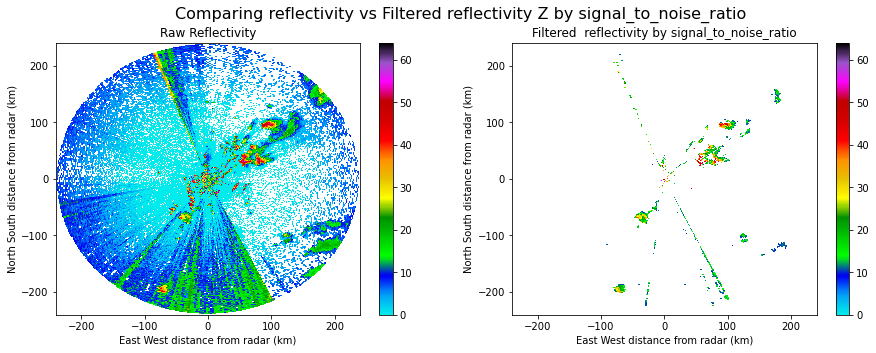

In [9]:
# create the plot
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('reflectivity', 0, ax=ax1, vmin=0, vmax=64., 
                 colorbar_label='', cmap=pyart.graph.cm.NWSRef,
                 title='Raw Reflectivity')

ax2 = fig.add_subplot(122)
display.plot_ppi('signal_to_noise_ratio', 0, vmin=0, vmax=64., 
                 colorbar_label='', cmap=pyart.graph.cm.NWSRef, ax=ax2, gatefilter = gtfilter,
                 title='Filtered  reflectivity by signal_to_noise_ratio')

plt.suptitle('Comparing reflectivity vs Filtered reflectivity Z by signal_to_noise_ratio', fontsize=16)
plt.show()


* ผลนี้เป็นเพียงการใช้ gatgilter เพื่อแสดงด้วยการพลอต แต่จริงๆ แล้วจะต้องทำการ mask แล้วทำการแอดฟิวด์เข้าไป และทำการ save ออกไปเพื่อจะได้เป็นข้อมูลที่ถาวร
* ต่อจากนั้นให้ทำการปรับแก้ค่า attenuation reflectivity และต่อด้วยการปรับแก้ค่า differential phase fields
* คำนวณค่า KDP แล้วค่อยทำการ classify หยาดน้ำฟ้าด้วย CSU tools

## ทำการ mask พื้นที่และเพิ่มฟิวด์เข้าไปในเรดาร์ออปเจ็กค์

* จะแปลง gatefilter ไปเป็นเรดาร์ออปเจ็กค์ยังไง งง เพราะมันเป็นชนิด boolean ที่มีขนาดรูปร่างเท่ากับ เรดาร์ออปเจ็กค์ ลองดูโค้ดนี้ https://arm-doe.github.io/pyart/examples/mapping/plot_map_two_radars_to_grid.html#sphx-glr-examples-mapping-plot-map-two-radars-to-grid-py
* ใน https://openradarscience.org/erad2022/notebooks/pyart/exercice1_swiss_thunderstorm.html เขาทำการปรับแก้ attenuation ต่อเลย โดยใช้ "gatefilter=gtfilter" แล้วได้ผลลัพธ์เป็นหนึ่งฟิวด์ที่ชื่อ 'corrected_reflectivity' แล้วก็เอาฟิวด์นี้ไปใช้งานต่อได้เลยในการจำแนกหยาดน้ำฟ้า
* ให้ใช้ลิงก์นี้ในการทำ mask แล้วนำไปคูณกับค่าที่ต้องการกรอง แล้ว add field เข้าไปใน radar object จากนั้น export field ที่ต้องการออกไปเป็นไฟล์ใช้ต่อไป https://arm-doe.github.io/pyart/notebooks/changing_fields_and_saving.html

# 2. การปรับแก้ค่า differential phase fields
https://github.com/ARM-DOE/pyart/issues/109

https://jjhelmus.github.io/pyart/dev/auto_examples/correct/plot_lp_phase_proc.html

## คำนวณฟิวด์ normalized coherent power NCP ขึ้นมาใหม่ 
ตรงนี้เนื่องจากเชียงรายไม่มีข้อมูล NCP เลยต้องทำการจำลองว่าทุกพื้นที่มีค่าเท่ากับ 1 คล้าย ๆ ข้อมูลสมมติขึ้นมา

In [10]:
# See what moments are present.
radar.fields.keys()

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio'])

In [11]:
ncp_values = np.ones((radar.nrays, radar.ngates))
ncp = pyart.config.get_metadata('normalized_coherent_power')
ncp['data'] = ncp_values
radar.add_field('normalized_coherent_power', ncp)

In [12]:
# See what moments are present.
radar.fields.keys()

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power'])

C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


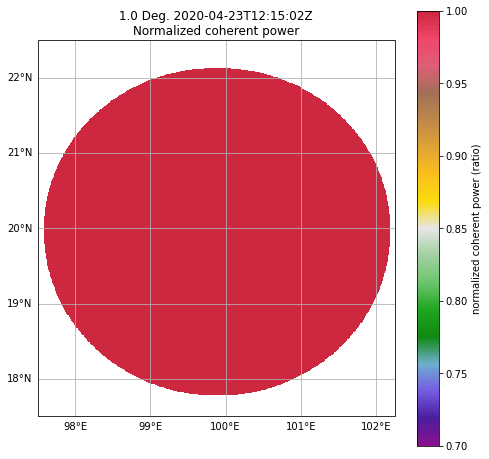

In [13]:
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('normalized_coherent_power', sweep=0, resolution='50m',
                     vmin=0.7, vmax=1.0, max_lat = 22.5, min_lat =17.5, min_lon = 97.5, max_lon = 102.25,
                     projection=ccrs.PlateCarree(), lat_lines = np.arange(16,24,1.0), lon_lines = np.arange(96, 104, 1.0))
plt.show()

## ประมาณค่า KDP

โมเมนต์ KDP หากมีค่าที่สูงแสดงถึงว่ามีหยดฝนที่มีขนาดใหญ่คล้าย คือ มีด้านขวางยาวกว่าด้านแนวตั้ง แสดงถึงกลุ่มฝนที่หนัก สามารถนำ KDP ไปใช้ในการจำแนกหยาดน้ำฟ้าได้ ค่า KDP เป็นค่าที่ได้จากการคำนวณจากค่า PHIDP  

Another very interesting radar variable is the specific differential phase shift KDP. Large KDP indicates the presence of large oblate drops and is linked to very strong precipitation. KDP is also needed for the hydrometeor classification algorithm. However KDP is not measured directly and needs to be estimated numerically from the raw differential phase shift (PHIDP). Py-ART provides three different retrieval methods. We will use the method by Maesaka et al. (2012) which is fast and robust but assumes KDP to be positive and is therefore limited to rainfall below the melting layer and/or warm clouds.

In [14]:
kdp, _, _ = pyart.retrieve.kdp_maesaka(radar, gatefilter = gtfilter,
                                       psidp_field = 'differential_phase')
radar.add_field('cal_specific_differential_phase', kdp, replace_existing=True)


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [15]:
# See what moments are present.
radar.fields.keys()

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase'])

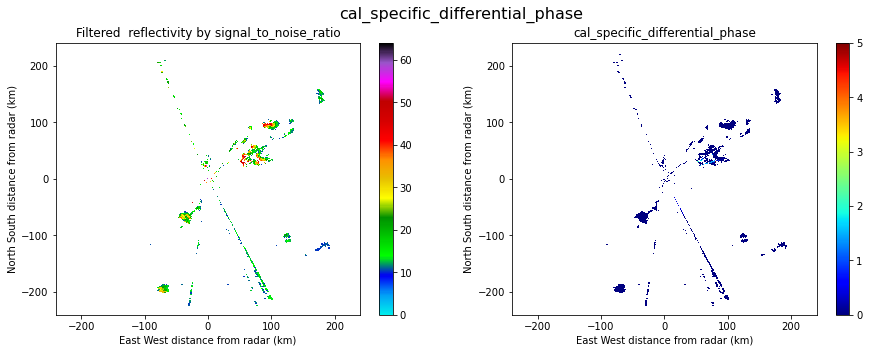

In [16]:
#fig, ax = plt.subplots(1,1, figsize=(6,6))
#display = pyart.graph.RadarDisplay(radar)
#display.plot_ppi('cal_specific_differential_phase', 0, vmin = 0, vmax = 5, cmap='jet',
#                 ax = ax,  gatefilter = gtfilter)

#ax.set_xlim([-200,200])
#ax.set_ylim([-200,200])
#ax.set_aspect('equal', 'box')


# create the plot
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
display.plot_ppi('signal_to_noise_ratio', 0, vmin=0, vmax=64., 
                 colorbar_label='', cmap=pyart.graph.cm.NWSRef, gatefilter = gtfilter,
                 title='Filtered  reflectivity by signal_to_noise_ratio')

ax2 = fig.add_subplot(122)
display.plot_ppi('cal_specific_differential_phase', 0, vmin=0, vmax=5., 
                 colorbar_label='', cmap='jet', ax=ax2, gatefilter = gtfilter,
                 title='cal_specific_differential_phase')

plt.suptitle('cal_specific_differential_phase', fontsize=16)
plt.show()

# 3. ปรับแก้ค่า differential phase fields

In [17]:
phidp_corr, kdp_corr = pyart.correct.phase_proc_lp(radar, -2.0, self_const=60000.0, low_z=10.0,
                                     high_z=53.0, min_phidp=0.01, min_ncp=0.5,
                                     min_rhv=0.8, fzl=3900.0, overide_sys_phase=False,
                                     nowrap=291, LP_solver='pyglpk', window_len=35,
                                    proc=6, debug=False, really_verbose=False)
radar.add_field('proc_dp_phase_shift', phidp_corr, replace_existing=True)
radar.add_field('recalculated_diff_phase', kdp_corr, replace_existing=True)

C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /


In [18]:
# See what moments are present.
radar.fields.keys()

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase'])

## พลอต differential phase fields
https://jjhelmus.github.io/pyart/dev/auto_examples/correct/plot_lp_phase_proc.html

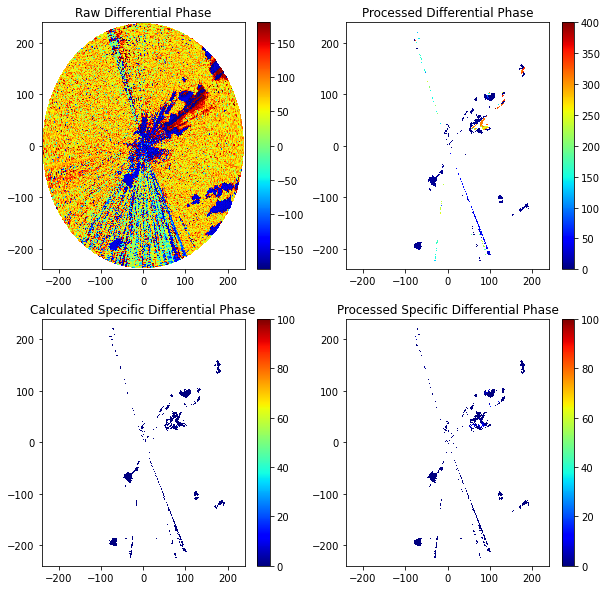

In [19]:
# create a plot of the various differential phase fields
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
display.plot_ppi('differential_phase', 0, ax=ax1,
                 title='Raw Differential Phase', colorbar_label='', cmap='jet',
                 axislabels_flag=False)

ax2 = fig.add_subplot(222)
display.plot_ppi('proc_dp_phase_shift', 0, ax=ax2,
                 title='Processed Differential Phase', colorbar_label='', cmap='jet', gatefilter = gtfilter,
                 axislabels_flag=False)

ax3 = fig.add_subplot(223)
display.plot_ppi('cal_specific_differential_phase', 0, ax=ax3,
                 title='Calculated Specific Differential Phase', colorbar_label='', cmap='jet',vmin=0,  vmax=100, gatefilter = gtfilter,
                 axislabels_flag=False)

ax4 = fig.add_subplot(224)
display.plot_ppi('recalculated_diff_phase', 0, ax=ax4,  cmap='jet',
                 title='Processed Specific Differential Phase', vmin=0,  vmax=100, gatefilter = gtfilter,
                 colorbar_label='',
                 axislabels_flag=False)
plt.show()

Calculated Specific Differential Phase กับ Processed Specific Differential Phase ให้ผลลัพธ์คล้าย ๆ กัน  ผลลัพธ์เหล่านี้ยกเว้นภาพแรก ใช้ gatefilter ของ SNR

## พลอต กราฟเปรียบเทียบ differential phase fields

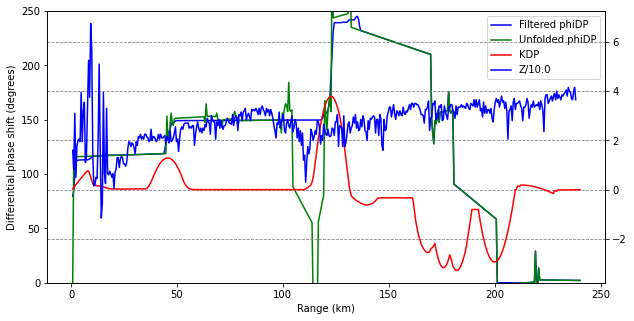

In [20]:
# plot a fields from a single ray
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)
ray_num = 59 #60

# filtered phidp and unfolded phidp
display.plot_ray('proc_dp_phase_shift', ray_num, format_str='b-',
                 axislabels_flag=False, title_flag=False, ax=ax)

display.plot_ray('unfolded_differential_phase', ray_num, format_str='g-',
                 axislabels_flag=False, title_flag=False, ax=ax)

# set labels
ax.set_ylim(0, 250)
ax.set_ylabel('Differential phase shift (degrees)')
ax.set_xlabel('Range (km)')

# plot KDP and reflectivity on second axis
ax2 = ax.twinx()
display.plot_ray('recalculated_diff_phase', ray_num, format_str='r-',
                 axislabels_flag=False, title_flag=False, ax=ax2)
radar.add_field_like('reflectivity', 'scaled_reflectivity',
                     radar.fields['reflectivity']['data']/10.)
display.plot_ray('scaled_reflectivity', ray_num, format_str='b-',
                 axislabels_flag=False, title_flag=False, ax=ax2)

# decorate
ax2.yaxis.grid(color='gray', linestyle='dashed')
ax.legend(display.plots,
          ["Filtered phiDP", "Unfolded phiDP", 'KDP', 'Z/10.0'],
          loc='best')
plt.show()

ต่อไปจะทำการปรับแก้ attenuation ของค่า reflectivity

# ปรับแก้ attenuation correction of reflectivity
โค้ดจาก https://jjhelmus.github.io/pyart/dev/auto_examples/correct/plot_attenuation.html

In [21]:
# See what moments are present.
radar.fields.keys()

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'scaled_reflectivity'])

In [22]:
# perform attenuation correction
spec_at, cor_z = pyart.correct.calculate_attenuation(
    radar, 0, refl_field='reflectivity',
    ncp_field='normalized_coherent_power', rhv_field='cross_correlation_ratio',
    phidp_field='proc_dp_phase_shift')
radar.add_field('specific_attenuation', spec_at)
radar.add_field('corrected_reflectivity_horizontal', cor_z)

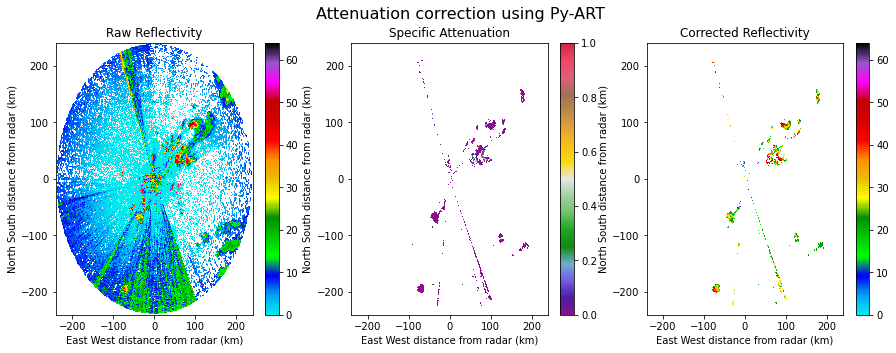

In [23]:
 #create the plot
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('reflectivity', 0, ax=ax1, vmin=0, vmax=64.,
                 colorbar_label='', cmap=pyart.graph.cm.NWSRef,
                 title='Raw Reflectivity')

ax2 = fig.add_subplot(132)
display.plot_ppi('specific_attenuation', 0, vmin=0, vmax=1.0, gatefilter = gtfilter,
                 colorbar_label='', ax=ax2,
                 title='Specific Attenuation')

ax3 = fig.add_subplot(133)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_reflectivity_horizontal', 0, vmin=0, vmax=64., cmap=pyart.graph.cm.NWSRef, gatefilter = gtfilter,
                 colorbar_label='', ax=ax3,
                 title='Corrected Reflectivity')

plt.suptitle('Attenuation correction using Py-ART', fontsize=16)
plt.show()

ต่อไปจะทำการจำแนกชนิดหยาดน้ำฟ้าโดยใช้ CSU Tool ร่วมกับข้อมูล sounding ที่ได้จากการจำลอง ERA-5

# 4. พลอตตัวแปร radar moments สำหรับ Fig.2 ใน manuscripts

หลังจากที่ทำการ preprocessing ค่า radar moments แล้ว จะทำการพลอตค่าทั้งหมดเพื่อแสดงใน Fig.2 ของ manuscripts ก่อนนำไปใช้ในการจำแนกหยาดน้ำฟ้า

In [24]:
# See what moments are present.
radar.fields.keys()

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'scaled_reflectivity', 'specific_attenuation', 'corrected_reflectivity_horizontal'])

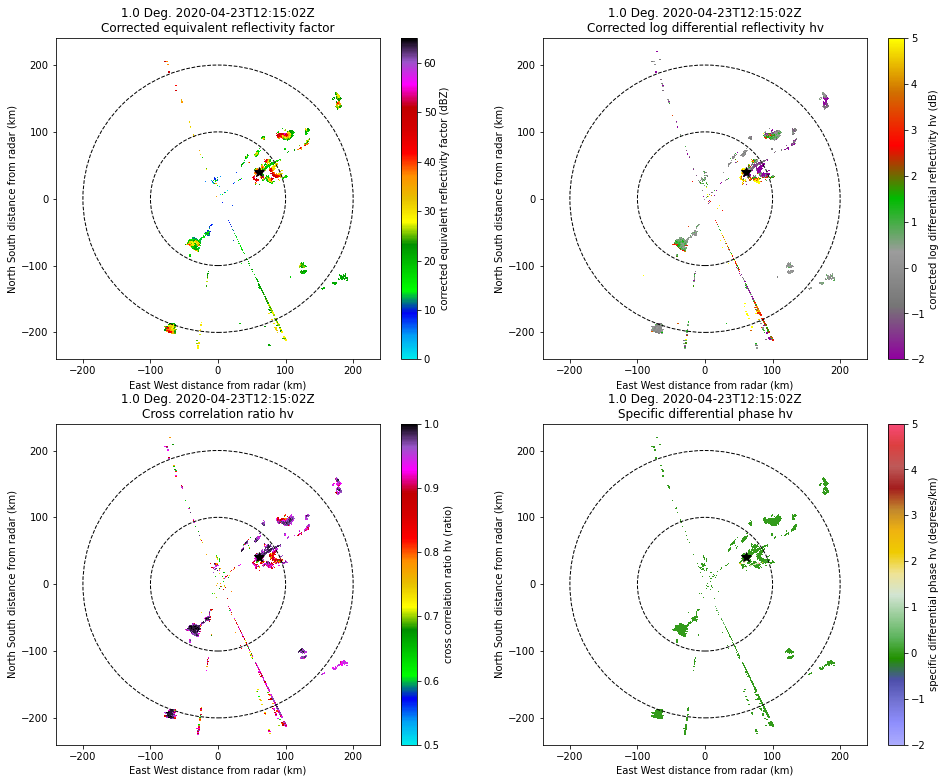

In [25]:
fig = plt.figure(figsize=[16,13])
ax1 = plt.subplot(2,2,1)
display = pyart.graph.RadarMapDisplay(radar)
display.plot('corrected_reflectivity_horizontal', sweep=0, gatefilter = gtfilter, vmin=0, vmax=65, cmap=pyart.graph.cm.NWSRef) 

ax2 = plt.subplot(2,2,2)
display = pyart.graph.RadarMapDisplay(radar)
display.plot('corrected_differential_reflectivity', sweep=0, gatefilter = gtfilter, vmin=-2, vmax=5,cmap='pyart_NWS_SPW')  #Differential Reflectivity (ZDR)

ax3 = plt.subplot(2,2,3)
display = pyart.graph.RadarMapDisplay(radar)
display.plot('cross_correlation_ratio', sweep=0, gatefilter = gtfilter, vmin=0.5, vmax=1.0,cmap=pyart.graph.cm.NWSRef) 


ax4 = plt.subplot(2,2,4)
display = pyart.graph.RadarMapDisplay(radar)
display.plot('cal_specific_differential_phase', sweep=0, gatefilter = gtfilter, vmin=-2.0, vmax=5.0,cmap='pyart_Theodore16') # derived KDP 
#Specific Differential Phase is a derived product that shows the gradient, or change, in Differential Phase Shift (ΦDP).

ax1.plot(60.0, 40.0, "k*", zorder=5, markersize=10)
ax2.plot(60.0, 40.0, "k*", zorder=5, markersize=10)
ax3.plot(60.0, 40.0, "k*", zorder=5, markersize=10)
ax4.plot(60.0, 40.0, "k*", zorder=5, markersize=10)

circle200 = plt.Circle((0.0, 0.0), 200.00, color='k', fill=False, ls='--', lw= 1.0)
circle100 = plt.Circle((0.0, 0.0), 100.00, color='k', fill=False, ls='--', lw= 1.0)
ax1.add_patch(plt.Circle((0.0, 0.0), 200.00, color='k', fill=False, ls='--', lw= 1.0))
ax1.add_patch(plt.Circle((0.0, 0.0), 100.00, color='k', fill=False, ls='--', lw= 1.0))
ax2.add_patch(plt.Circle((0.0, 0.0), 200.00, color='k', fill=False, ls='--', lw= 1.0))
ax2.add_patch(plt.Circle((0.0, 0.0), 100.00, color='k', fill=False, ls='--', lw= 1.0))
ax3.add_patch(plt.Circle((0.0, 0.0), 200.00, color='k', fill=False, ls='--', lw= 1.0))
ax3.add_patch(plt.Circle((0.0, 0.0), 100.00, color='k', fill=False, ls='--', lw= 1.0))
ax4.add_patch(plt.Circle((0.0, 0.0), 200.00, color='k', fill=False, ls='--', lw= 1.0))
ax4.add_patch(plt.Circle((0.0, 0.0), 100.00, color='k', fill=False, ls='--', lw= 1.0))

plt.show()

# 5.จำแนกชนิดหยาดน้ำฟ้า HID/HCA
* จำแนกหยาดน้ำฟ้า ของ Timothy Lang จาก https://github.com/openradar/AMS-Short-Course-on-Open-Source-Radar-Software/blob/master/9a_CSU_RadarTools_Demo-AMS_OSRSC.ipynb
ยังใช้ sounding ของ darwin อยู่

* ให้ศึกษาวิธีการสกัดค่าตัวแปรบรรยากาศจากข้อมูล ERA5 เพื่อนำมาสร้างข้อมูล sounding ใน SHARPpy https://www.youtube.com/watch?v=C3YwOG8btMk
* โปรแกรม SHARPpy ติดตั้งจากไบนารีหรือconda https://sharppy.github.io/SHARPpy/interpreting_gui.html
* ยูทูปสอนการใช้งาน SHARPpy https://www.youtube.com/watch?v=nyeuYcS1U90
* สา่มารถนำค่า sounding มาพลอตและคำนวนค่าเทอร์โมไดนามิกส์ได้ด้วยการใช้ metpy https://unidata.github.io/MetPy/latest/examples/Advanced_Sounding.html
* สามารถใช้ skewT https://pypi.org/project/SkewT/ ในการพลอตและคำนวณค่าเทอร์โมไดนามิกส์จากข้อมูล sounding ได้ แต่ในวันที่ 23 เมษายน 2563 สถานีเชียงใหม่ไม่มีข้อมูล
* รายชื่อสถานีตัวอากาศชั้นบนของประเทศไทย สามารถหาได้จากเอกสารนี้ https://library.wmo.int/doc_num.php?explnum_id=9896 แล้วสามารถนำเอาชื่อสถานีไปค้นหาข้อมูลของช่วงเวลาที่ต้องการได้จากเวป http://weather.uwyo.edu/upperair/sounding.html

In [26]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pyart
import glob
#from pyart.io.common import radar_coords_to_cart
from pyart.core.transforms import antenna_to_cartesian as radar_coords_to_cart # มันเปลี่ยนที่อยู่ไปเก็บไว้ที่ core C:\Users\Admin\anaconda3\envs\pyart\Lib\site-packages\pyart\core
from skewt import SkewT 
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc)
%matplotlib inline

C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\csu_radartools-1.3.0.dev0-py3.10-win-amd64.egg\csu_radartools\csu_misc.py:18: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [27]:
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65, cmap1=pyart.graph.cm.NWSRef, 
                   units1='dBZ', var2='differential_reflectivity', vmin2=-5, vmax2=5, 
                   cmap2='RdYlBu_r', units2='dB', return_flag=False, xlim=[-150,150],
                   ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13, 5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

## ใช้ข้อมูล sounding สร้างเองจาก reanalysis

In [28]:
# ทดลองใช้ข้อมูล sounding ของเมืองดาร์วิน ต่อไปต้องสร้างเองจาก reanalysis
#Read in the data
sndfile = './0data/era5_23042020_1100utc_wyoming.txt'
#radarfile = './0data/0Hail_CRI23Apr2020/CRI240@202004231145.uf' # เรดาร์เชียงราย
#radar = pyart.io.read(radarfile)
print(radar.fields.keys())
sounding = SkewT.Sounding(sndfile)

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'scaled_reflectivity', 'specific_attenuation', 'corrected_reflectivity_horizontal'])


In [29]:
sounding

{'StationNumber': '48303', 'SoundingDate': '2020-04-23_11:00:00'}

In [30]:
# ตรงนี้ไม่ต้อง เราจะใช้ KDP ที่คำนวณไว้ก่อนหน้านี้แทน
## คำนวณ KDP 
#kdp, phidpr=pyart.retrieve.kdp_proc.kdp_vulpiani(radar) #

# add fiedl KDP 
#radar.add_field('specific_differential_phase_hv', kdp, replace_existing=True)  

#print(radar.fields.keys())

In [31]:
dz = radar.fields['corrected_reflectivity_horizontal']['data']
dr = radar.fields['corrected_differential_reflectivity']['data']
#kd = radar.fields['specific_differential_phase_hv']['data']
kd = radar.fields['recalculated_diff_phase']['data']
rh = radar.fields['cross_correlation_ratio']['data']

In [32]:
def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']


def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    if not snd_T.mask[0]:  # May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    dummy_z.append(snd_z[i])
                    dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    return snd_T, snd_z


def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z

In [33]:
sounding

{'StationNumber': '48303', 'SoundingDate': '2020-04-23_11:00:00'}

In [34]:
radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)

In [35]:
scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True, band='C',
                                T=radar_T)
fh = np.argmax(scores, axis=0) + 1

In [36]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='corrected_reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

In [37]:
radar = add_field_to_radar_object(scores, radar)

In [38]:
hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)
cmapmeth = colors.ListedColormap(hid_colors[0:6])
cmapmeth_trop = colors.ListedColormap(hid_colors[0:7])

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)', 'R(Zrain)'])
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z_all)', 'R(Z_c)', 'R(Z_s)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

# พลอตภาพมุมยก 1

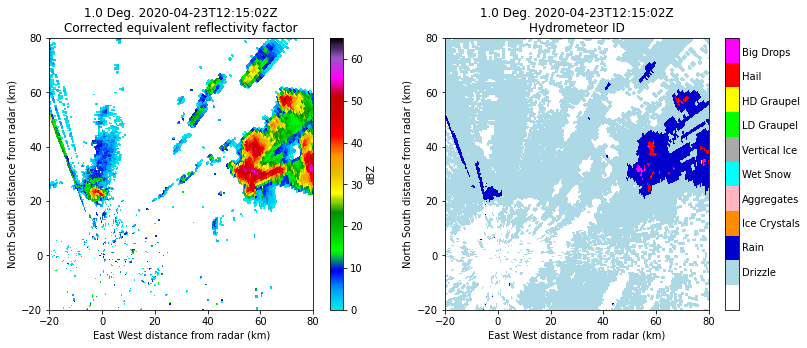

In [39]:
# Actual plotting done here
lim = [-20, 80]
fig, ax1, ax2, display = two_panel_plot(
    radar, sweep=0, var1='corrected_reflectivity', var2='FH', vmin2=0, vmax2=10, 
    cmap2=cmaphid, units2='', return_flag=True, xlim=lim, ylim=lim)
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])

# 6.พลอตภาพ Fig.4 ใน manuscript

In [40]:
# See what moments are present.
radar.fields.keys()

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'scaled_reflectivity', 'specific_attenuation', 'corrected_reflectivity_horizontal', 'FH'])

In [41]:
def six_panel_plot(radar, sweep1=0, sweep2=1, sweep3=2, sweep4=3,
                   var1='reflectivity', vmin1=0, vmax1=65, cmap1=pyart.graph.cm.NWSRef, units1='dBZ', 
                   var2='FH', vmin2=0, vmax2=10, cmap2=cmaphid, units2='', 
                   var4='cross_correlation_ratio', vmin4=0, vmax4=1.0,cmap4='pyart_RefDiff', units4='ratio',                                 
                   return_flag=False, xlim=[-150,150], ylim=[-150,150], gatefilter = gtfilter):
    display = pyart.graph.RadarDisplay(radar)    
    fig = plt.figure(figsize=(25, 15))
    
    ax1 = fig.add_subplot(231)
    display.plot_ppi(var1, sweep=sweep1, vmin=vmin1, vmax=vmax1, cmap=cmap1, #gatefilter = gtfilter,
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    
    ax2 = fig.add_subplot(232)
    display.plot_ppi(var2, sweep=sweep1, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    
    ax3 = fig.add_subplot(233)
    display.plot_ppi(var2, sweep=sweep2, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    
    ax4 = fig.add_subplot(234) #cross correlation hv
    display.plot_ppi(var4, sweep=sweep1, vmin=vmin4, vmax=vmax4, cmap=cmap4, #gatefilter = gtfilter,
                     colorbar_label=units4, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    
    ax5 = fig.add_subplot(235)
    display.plot_ppi(var2, sweep=sweep3, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    
    ax6 = fig.add_subplot(236)
    display.plot_ppi(var2, sweep=sweep4, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    
    if return_flag:
        return fig, ax1, ax2,ax3, ax4, ax5, ax6, display

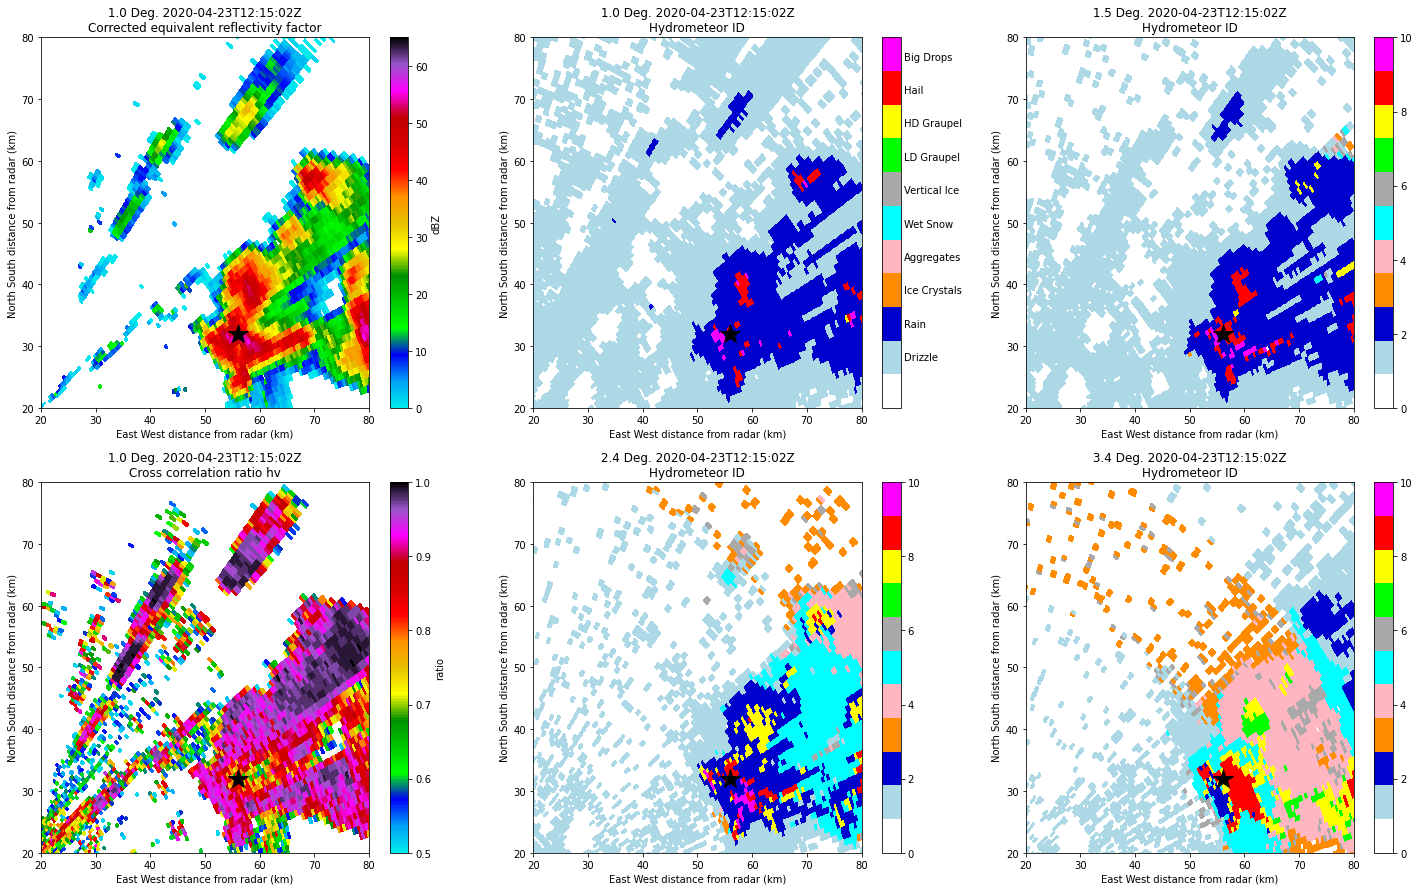

In [42]:
# พลอต 6 ภาพ 
lim = [20, 80]
fig, ax1, ax2,ax3, ax4, ax5, ax6, display = six_panel_plot(
    radar, sweep1=0, sweep2=1, sweep3=2, sweep4=3,
    var1='corrected_reflectivity', vmin1=0, vmax1=65, cmap1=pyart.graph.cm.NWSRef, units1='dBZ', 
    var2='FH', vmin2=0, vmax2=10, cmap2=cmaphid, units2='', 
    var4='cross_correlation_ratio', vmin4=0.5, vmax4=1.0,cmap4=pyart.graph.cm.NWSRef, units4='ratio',                                 
    return_flag=True, xlim=lim, ylim=lim, gatefilter = gtfilter)

#-ชื่อเชียงของ
ax1.plot(56.0, 32.0, "k*", zorder=5, markersize=20)
ax2.plot(56.0, 32.0, "k*", zorder=5, markersize=20)
ax3.plot(56.0, 32.0, "k*", zorder=5, markersize=20)
ax4.plot(56.0, 32.0, "k*", zorder=5, markersize=20)
ax5.plot(56.0, 32.0, "k*", zorder=5, markersize=20)
ax6.plot(56.0, 32.0, "k*", zorder=5, markersize=20)


#ax1.text(60.0 + 0.05, 40.0 + 0.05, "Chiang Khong District", fontsize="large")

display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])

## ขยายพื้นที่ลูกเห็บ

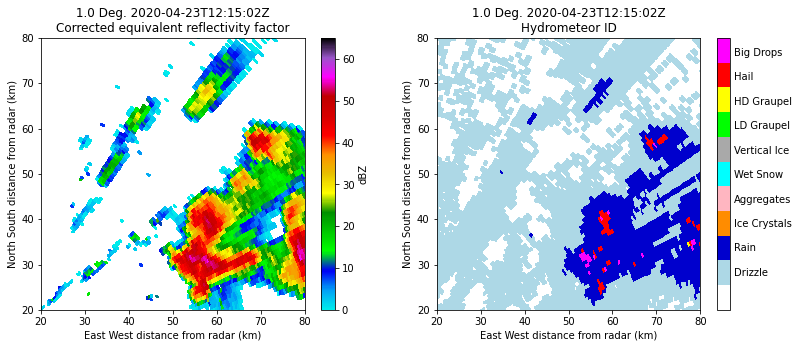

In [43]:
# Actual plotting done here
lim = [20, 80]
fig, ax1, ax2, display = two_panel_plot(
    radar, sweep=0, var1='corrected_reflectivity', var2='FH', vmin2=0, vmax2=10,
    cmap2=cmaphid, units2='', return_flag=True, xlim=lim, ylim=lim)
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])

In [44]:
scores = csu_fhc.csu_fhc_summer(dz=45.0, zdr=0.0, kdp=-0.2, rho=0.95, T=-1)
print(scores)
print(np.argmax(scores, axis=0) + 1) #ประเภทไหนมีมากที่สุด

8
1
